In [3]:
#Codice dell'agente DQN
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import numpy as np
import random
import os

class DQNAgent():
    def __init__(self, env, iterations=201, alpha= 0.001, epsilon=1, gamma=0.99, epsilon_reduction=0.05, model_name="cervello_positronico"):
        #variabili dell'ambiente
        self.env = env
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.state_shape = self.env.observation_space.shape
        self.max_iterations = iterations

        #replay memory e campione
        self.memory = deque(maxlen=20000)
        self.mem_sample = 32

        #learning rate
        self.alpha = alpha

        #exploration
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_reduction = epsilon_reduction

        #futuro 
        self.gamma = gamma

        #creazione delle due reti neurali, quella dell'addestramento e quella stabile
        self.model_name = model_name
        self.train_model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.train_model.get_weights())

    def create_model(self):
        model = Sequential()
        model.add(Dense(24, activation='relu', input_shape=self.state_shape))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(lr=self.alpha))

        return model

    #scelta dell'azione in base ad epsilon
    def choose_action(self, state):
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.rand(1) < self.epsilon:
            return np.random.randint(0, 3)
        else:
            return np.argmax(self.train_model.predict(state)[0])

    def train_from_memory(self):
        if len(self.memory) < self.mem_sample:
            return

        minibatch = random.sample(self.memory, self.mem_sample)

        states = []
        new_states=[]

        for state, action, reward, new_state, done in minibatch:
            states.append(state)
            new_states.append(new_state)
        
        na = np.array(states)
        states = na.reshape(self.mem_sample, 2)
        na2 = np.array(new_states)
        new_states = na2.reshape(self.mem_sample, 2)

        targets = self.train_model.predict(states)
        new_state_targets=self.target_model.predict(new_states)

        i=0
        for state, action, reward, new_state, done in minibatch:
            target = targets[i]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * max(new_state_targets[i])
            i+=1
        
        self.train_model.fit(states, targets, epochs=1, verbose=0)

    #salvataggio del cervellone
    def save_model(self, name):
        self.train_model.save(name)
        print("___Model Saved___")

    def load_model(self, name):
        self.target_model.load_weights(name)
        self.train_model.load_weights(name)
        print("___Model Loaded___")

    #memorizzazione degli stati
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def fit(self, episode, state, render):
        total_reward = 0
        record = self.env.observation_space.low[0]

        for epoch in range(self.max_iterations):
            if render and episode % 50 == 0:
                self.env.render()
            
            action = self.choose_action(state)
            new_state, reward, done, _ = self.env.step(action)
            new_state = new_state.reshape(1,self.state_size)

            if new_state[0][0] > record:
                record = new_state[0][0]

            if new_state[0][0] >= 0.5:
                reward += 10


            self.memorize(state, action, reward, new_state, done)
            self.train_from_memory()

            total_reward += reward
            state = new_state

            if done:
                break

        if epoch >= 199:
            print("Failed to finish task in epsoide {}".format(episode))
        else:
            print("Success in epsoide {}, used {} iterations!".format(episode,epoch))
            self.save_model('trained_model.h5')

        #Sync
        self.target_model.set_weights(self.train_model.get_weights())

        print("--now epsilon is {}, the reward is {} maxPosition is {}".format(max(self.epsilon, self.epsilon_min), total_reward,record))
        self.epsilon -= self.epsilon_reduction

        return total_reward, epoch
    
    def start_training(self, episodes=400, render=False):
        total_rewards=[]
        total_epochs=[]
        
        try:
            for episode in range(episodes):
                state = env.reset().reshape(1,self.state_size)
                total_reward, epoch = self.fit(episode, state, render)

                total_epochs.append(epoch+1)
                total_rewards.append(total_reward)
        finally:
            self.env.close()

        return total_rewards, total_epochs

    def play(self, filename, trials=400, render=True):
        epochs = []
        done = False
        successes = []
        self.load_model(filename)
        try:
            for episode in range(trials):
                state = self.env.reset()
                state = np.reshape(state, (1, self.state_size))

                succ = 0
                for i in range(self.max_iterations):
                    if render:
                        self.env.render()
                    action = np.argmax(self.train_model.predict(state)[0])

                    next_state, reward, done, _ = self.env.step(action)
                    next_state = np.reshape(next_state, (1, self.state_size))

                    if next_state[0][0] >= 0.5:
                        succ = 1
                    state = next_state
                print("Completed/Episodes {}/{}, success = {}".format(episode + 1, trials, succ))
                successes.append(succ)
                epochs.append(i+1)
        finally:
            self.env.close()

        return epochs, successes

Using TensorFlow backend.
/Users/ramorimo/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ramorimo/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ramorimo/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ramorimo/venv/lib/python3.7/site-packages/tensorflow/py

In [5]:
import gym

#creazione dell'ambiente e dell'agente
env = gym.make('MountainCar-v0')
pippo = DQNAgent(env, epsilon_reduction=0.05)

/Users/ramorimo/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [78]:
#addestramento del pilota Pippo
episodes = 400
total_rewards, total_epochs = pippo.start_training(episodes, False)

epsoide 255, used 93 iterations!
___Model Saved___
--now epsilon is 0.01, the reward is -84.0 maxPosition is 0.5006976415178602
Success in epsoide 256, used 186 iterations!
___Model Saved___
--now epsilon is 0.01, the reward is -177.0 maxPosition is 0.5327854779224
Success in epsoide 257, used 83 iterations!
___Model Saved___
--now epsilon is 0.01, the reward is -74.0 maxPosition is 0.5244721463153681
Success in epsoide 258, used 192 iterations!
___Model Saved___
--now epsilon is 0.01, the reward is -183.0 maxPosition is 0.5259220449717017
Failed to finish task in epsoide 259
--now epsilon is 0.01, the reward is -200.0 maxPosition is -0.40363077136876396
Success in epsoide 260, used 87 iterations!
___Model Saved___
--now epsilon is 0.01, the reward is -78.0 maxPosition is 0.5143122646624546
Failed to finish task in epsoide 261
--now epsilon is 0.01, the reward is -200.0 maxPosition is -0.5860637333248039
Success in epsoide 262, used 182 iterations!
___Model Saved___
--now epsilon is 0.

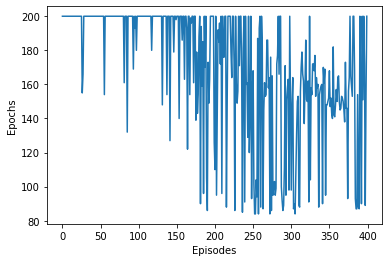

In [79]:
import matplotlib.pyplot as plt

plt.xlabel("Episodes")
plt.ylabel("Epochs")
plt.plot(range(episodes), total_epochs)

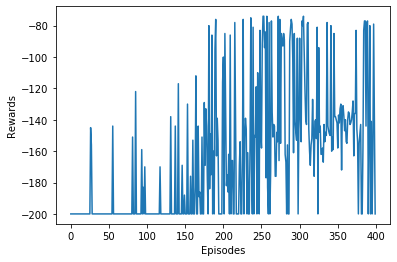

In [80]:
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.plot(range(episodes), total_rewards)

In [7]:
#test del pilota
pippo2 = DQNAgent(env, epsilon=0.0)
trials = 10
epochs, successes = pippo2.play("trained_model.h5", trials, render=False)

___Model Loaded___
Completed/Episodes 1/10, success = 1
Completed/Episodes 2/10, success = 1
Completed/Episodes 3/10, success = 1
Completed/Episodes 4/10, success = 1
Completed/Episodes 5/10, success = 1
Completed/Episodes 6/10, success = 1
Completed/Episodes 7/10, success = 1
Completed/Episodes 8/10, success = 1
Completed/Episodes 9/10, success = 1
Completed/Episodes 10/10, success = 1


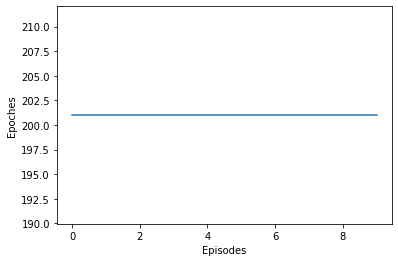

In [8]:
import matplotlib.pyplot as plt

plt.xlabel("Episodes")
plt.ylabel("Epoches")
plt.plot(range(trials), epochs)

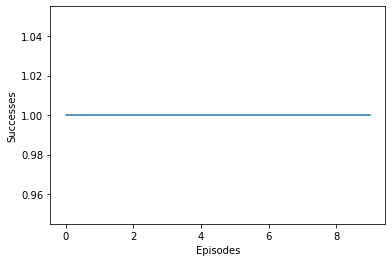

In [9]:
plt.xlabel("Episodes")
plt.ylabel("Successes")
plt.plot(range(len(successes)), successes)